In [1]:
import os
from datetime import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

In [2]:
from model import AutoFormer
from datasets import ExchangeDataset
from utils.data import split_data
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric

In [3]:
# Global Constants
CSV_PATH = "data/exchange_rate/exchange_rate.csv"
TARGET_COLUMN = "OT"
DATE_COLUMN = "date"

TRAIN_PERC = .7
TEST_PERC = .1
BATCH_SIZE = 32

SEQ_LEN = 96 #Input Sequence Length
START_TOKEN_LEN = 48 #Start Token Length
PRED_LEN = 96 #Prediction sequence length
FEATURES = "M"
OUTPUT_ATTENTION = False

EPOCHS = 50
LR = .0001
LRADJ = "type1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Prepare Data

In [4]:
# Read Data
df = pd.read_csv(CSV_PATH)
df

,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,1990/1/2 0:00,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,1990/1/3 0:00,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,1990/1/4 0:00,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,1990/1/5 0:00,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...,...
7583,2010/10/6 0:00,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
7584,2010/10/7 0:00,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
7585,2010/10/8 0:00,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943
7586,2010/10/9 0:00,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,0.692689


In [5]:
# Carve out date index and features
dates = pd.to_datetime(df.iloc[:, 0])
data = df.iloc[:, 1:]

(train_data, train_time_feat), (val_data, val_time_feat), (test_data, test_time_feat) = split_data(data, dates, TRAIN_PERC, TEST_PERC)

In [6]:
print("train", train_data.shape, train_time_feat.shape)
train_dataset = ExchangeDataset(data=train_data,
                                   time_feat=train_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

print("validation", val_data.shape, val_time_feat.shape)
val_dataset = ExchangeDataset(data=val_data,
                                   time_feat=val_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)
print("test", test_data.shape, test_time_feat.shape)

test_dataset = ExchangeDataset(data=test_data,
                                   time_feat=test_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

train (5311, 8) (5311, 3)
validation (1519, 8) (1519, 3)
test (758, 8) (758, 3)


 ## Prepare Model

In [7]:
af_model = AutoFormer()
opt = torch.optim.Adam(af_model.parameters(), lr=.0001)
criterion = torch.nn.MSELoss()

af_model.to(DEVICE)

AutoFormer(
  (decomp): SeriesDecomp(
    (moving_avg): MovingAvg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(8, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(8, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Enc

In [8]:
def train_step(af_model, train_loader, model_optim, criterion, device):
    train_loss_list = []

    af_model.train()
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):

        model_optim.zero_grad()
        batch_x = batch_x.float().to(device)

        batch_y = batch_y.float().to(device)
        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -PRED_LEN:, :]).float()
        dec_inp = torch.cat([batch_y[:, :START_TOKEN_LEN, :], dec_inp], dim=1).float().to(device)

        outputs = af_model(batch_x, batch_x_mark, dec_inp, batch_y_mark, batch_y)

        f_dim = -1 if FEATURES == 'MS' else 0
        batch_y = batch_y[:, -PRED_LEN:, f_dim:].to(device)
        loss = criterion(outputs, batch_y)
        train_loss_list.append(loss.item())

        loss.backward()
        model_optim.step()

        train_loss = np.average(loss.detach().cpu().numpy())
        train_loss_list.append(train_loss)

    avg_train_loss = np.mean(train_loss_list)

    return avg_train_loss


In [9]:
def val_step(af_model, val_loader, criterion, device):
    val_loss_list = []
    af_model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -PRED_LEN:, :]).float()
            dec_inp = torch.cat([batch_y[:, :START_TOKEN_LEN, :], dec_inp], dim=1).float().to(device)
            # encoder - decoder

            outputs = af_model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if FEATURES == 'MS' else 0
            batch_y = batch_y[:, -PRED_LEN:, f_dim:].to(device)

            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss = criterion(pred, true)

            val_loss_list.append(loss)
            
    avg_val_loss = np.average(val_loss_list)

    return avg_val_loss

In [10]:
def test(af_model, test_loader, run_name, device):
    af_model.load_state_dict(torch.load(os.path.join('./checkpoints/' + run_name, 'checkpoint.pth')))

    preds = []
    trues = []
    inputs = []
    folder_path = './test_results/' + run_name + '/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    af_model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -PRED_LEN:, :]).float()
            dec_inp = torch.cat([batch_y[:, :START_TOKEN_LEN, :], dec_inp], dim=1).float().to(device)
            # encoder - decoder
            outputs = af_model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if FEATURES == 'MS' else 0
            batch_y = batch_y[:, -PRED_LEN:, f_dim:].to(device)
            outputs = outputs.detach().cpu().numpy()
            batch_y = batch_y.detach().cpu().numpy()
            inp = batch_x.detach().cpu().numpy()

            pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
            true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()
            

            preds.append(pred)
            trues.append(true)
            inputs.append(inp)
            
    preds = np.array(preds)
    trues = np.array(trues)
    inputs = np.array(inputs)

    print('test shape:', preds.shape, trues.shape)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    inputs = inputs.reshape(-1, inputs.shape[-2], inputs.shape[-1])
    print('test shape:', preds.shape, trues.shape)

    # result save
    folder_path = './results/' + run_name + '/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    mae, mse, rmse, mape, mspe = metric(preds, trues)
    print('mse:{}, mae:{}'.format(mse, mae))
    f = open("result.txt", 'a')
    f.write(run_name + "  \n")
    f.write('mse:{}, mae:{}'.format(mse, mae))
    f.write('\n')
    f.write('\n')
    f.close()

    np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
    np.save(folder_path + 'pred.npy', preds)
    np.save(folder_path + 'true.npy', trues)
    np.save(folder_path + 'inputs.npy', inputs)

    return inputs, preds, trues

## Train and Validate

In [11]:
#Train Step
run_name = f"run_{str(datetime.now().strftime('%s'))}"

path = os.path.join("./checkpoints/", run_name)
if not os.path.exists(path):
    os.makedirs(path)

train_steps = len(train_loader)
early_stopping = EarlyStopping(patience=3, verbose=True)

model_optim = optim.Adam(af_model.parameters(), lr=LR)
criterion = nn.MSELoss()

train_loss_list = []
val_loss_list = []
for epoch in range(EPOCHS):
    train_loss = train_step(af_model, train_loader, model_optim, criterion, DEVICE)
    val_loss = val_step(af_model, val_loader, criterion, DEVICE)

    early_stopping(val_loss, af_model, path)
    if early_stopping.early_stop:
        print("Early Stopping")
        break
    
    adjust_learning_rate(model_optim, epoch+1, adjust_type="type1", lr=LR)
    
    print(epoch, train_loss, val_loss)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)



Validation loss decreased (inf --> 0.590865).  Saving model ...
Updating learning rate to 0.0001
0 0.2478175124619156 0.5908648
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
1 0.22900394899770618 0.5976941
Validation loss decreased (0.590865 --> 0.569167).  Saving model ...
Updating learning rate to 2.5e-05
2 0.21755080062430351 0.5691666
Validation loss decreased (0.569167 --> 0.564794).  Saving model ...
Updating learning rate to 1.25e-05
3 0.20587582904845475 0.56479377
Validation loss decreased (0.564794 --> 0.564584).  Saving model ...
Updating learning rate to 6.25e-06
4 0.19952725637704133 0.5645845
EarlyStopping counter: 1 out of 3
Updating learning rate to 3.125e-06
5 0.19551889065187425 0.5651835
EarlyStopping counter: 2 out of 3
Updating learning rate to 1.5625e-06
6 0.1937287658220157 0.56461245
EarlyStopping counter: 3 out of 3
Early Stopping


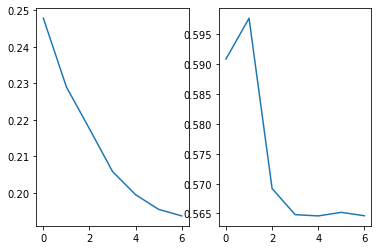

In [12]:
f, axarr = plt.subplots(1, 2)

x_index = [i for i in range(len(train_loss_list))]

axarr[0].plot(x_index, train_loss_list)
axarr[1].plot(x_index, val_loss_list)

## Test and visualize predicitons

In [15]:
input, pred, true = test(af_model, test_loader, run_name, DEVICE)
print(inputs.shape, preds.shape, trues.shape)

test shape: (17, 32, 96, 8) (17, 32, 96, 8)
test shape: (544, 96, 8) (544, 96, 8)
mse:0.7366719841957092, mae:0.6713383197784424
(544, 96, 8) (544, 96, 8) (544, 96, 8)


In [16]:
ss_indices = np.random.choice(range(pred.shape[0]), 2, replace=False)
ss_pred = pred[ss_indices]
ss_true = true[ss_indices]
ss_input = input[ss_indices]

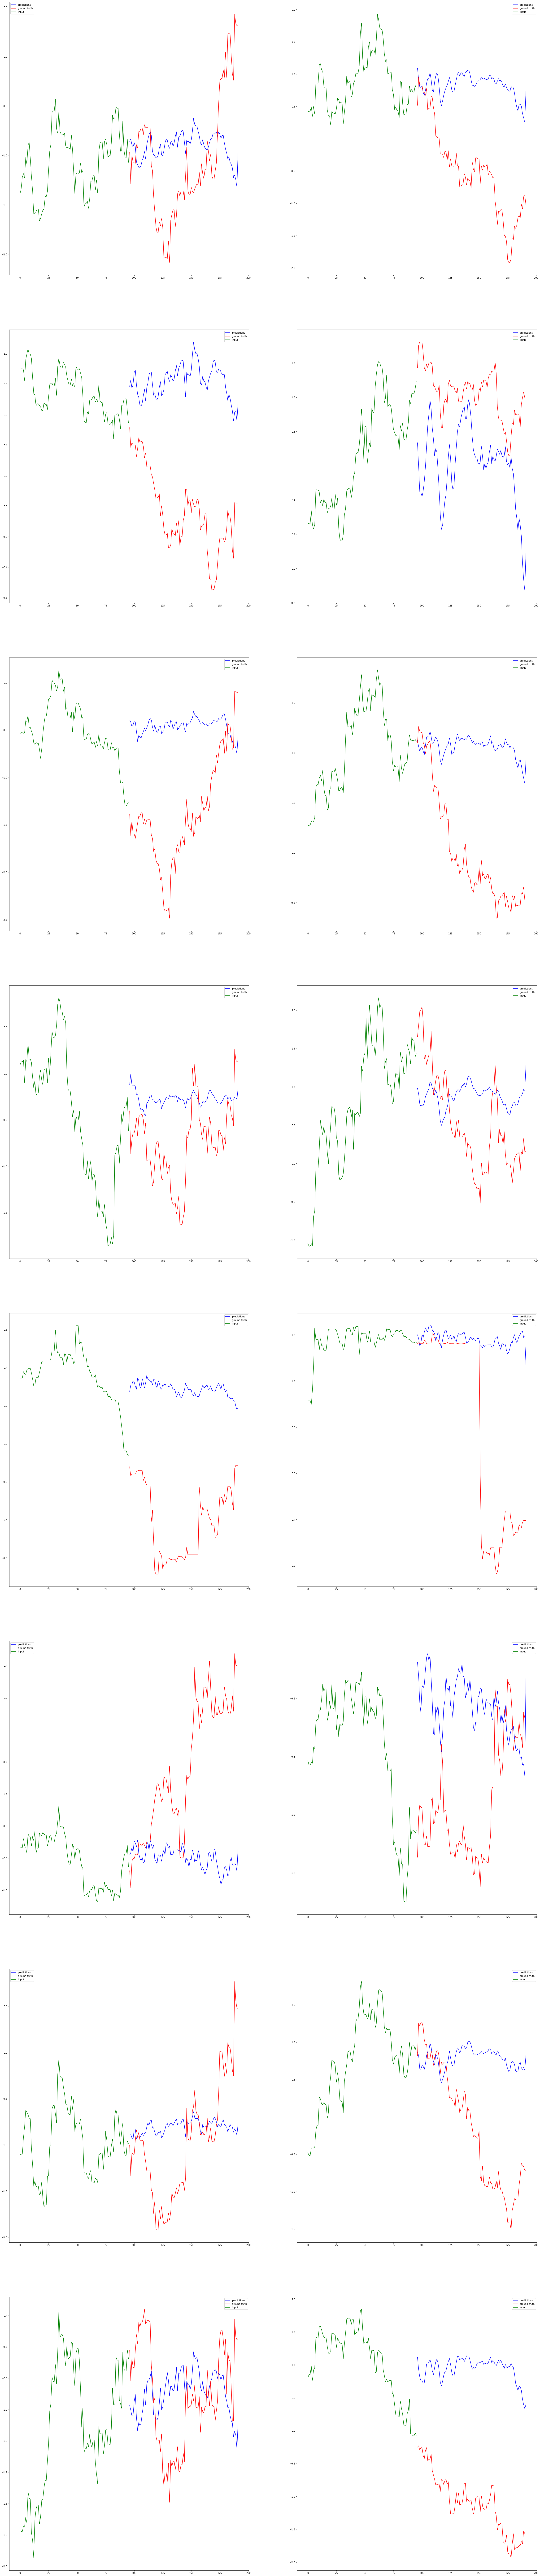

In [17]:
f, axarr = plt.subplots(pred.shape[2], ss_pred.shape[0], figsize=(40, 200))
for i in range(ss_pred.shape[2]):
    series_preds = ss_pred[:, :, i].squeeze()
    series_trues = ss_true[:, :, i].squeeze()
    series_inputs = ss_input[:, :, i].squeeze()
    for j in range(ss_pred.shape[0]):
        series_pred = series_preds[j, :].squeeze()
        series_true = series_trues[j, :].squeeze()
        series_input = series_inputs[j, :].squeeze()
        input_len = series_input.shape[0]
        pred_gt_len = series_pred.shape[0]

        input_x = np.array([i for i in range(input_len)])
        x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
        axarr[i, j].plot(x, series_pred, c="blue", label="predictions")
        axarr[i, j].plot(x, series_true, c="red", label="ground truth")
        axarr[i, j].plot(input_x, series_input, c="green", label="input")
        axarr[i, j].legend()